In [ ]:
!pip install yfinance pandas matplotlib numpy

In [27]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

In [28]:
data = yf.download('AAPL', start="2020-01-01", end="2025-08-01", auto_adjust=True)
data.columns = data.columns.droplevel(1)

[*********************100%***********************]  1 of 1 completed


In [29]:
data.head(-5)

Price,Close,High,Low,Open,Volume
Date,,,,,
2020-01-02,72.538528,72.598907,71.292319,71.545905,135480400
2020-01-03,71.833290,72.594055,71.608685,71.765667,146322800
2020-01-06,72.405663,72.444306,70.702997,70.954173,118387200
2020-01-07,72.065140,72.671333,71.845362,72.415330,108872000
2020-01-08,73.224426,73.526318,71.768101,71.768101,132079200
...,...,...,...,...,...
2025-07-18,210.940598,211.549907,209.462280,210.630951,48974600
2025-07-21,212.239120,215.535383,211.390093,211.859562,51377400
2025-07-22,214.156952,214.706331,211.989414,212.898386,46404100


In [30]:
data['MA50'] = data['Close'].rolling(window=50).mean()
data['MA200'] = data['Close'].rolling(window=200).mean()

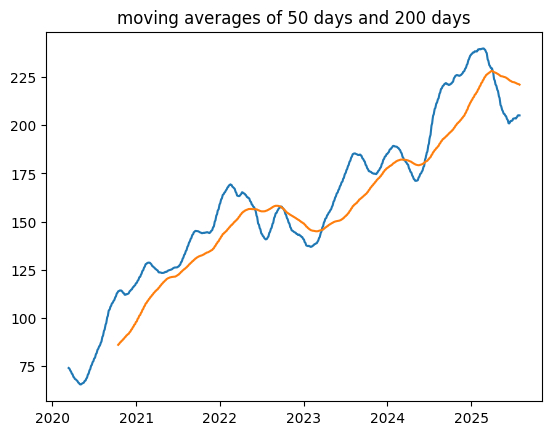

In [31]:
plt.title('moving averages of 50 days and 200 days')
plt.plot(data['MA50'])
plt.plot(data['MA200'])

In [ ]:
data['Signal'] = 0
data['Signal'][200:] = (data['MA50'][200:] > data['MA200'][200:]).astype(int) #we start @ day 200 bc no data for MA200 before that.
# we check if the MA50 @200th day is higher or lower than MA200 on that day


In [33]:
# Daily returns of the stock
data['Return'] = data['Close'].pct_change()   #pct change means percent change

# Strategy returns: only earn returns when Signal == 1
data['Strategy_Return'] = data['Signal'].shift(1) * data['Return']

#shifts the signal down by one day → you act on yesterday’s signal today (to avoid lookahead bias)

# Cumulative returns
data['Cumulative_Market'] = (1 + data['Return']).cumprod()  #cumprod means compound product. ie 1 dollar is invested just compounded over time.
data['Cumulative_Strategy'] = (1 + data['Strategy_Return']).cumprod() # 1 dollar is invested as per the strategy. so if yesyerdays signal was 0 or -1 we do not earn anything.

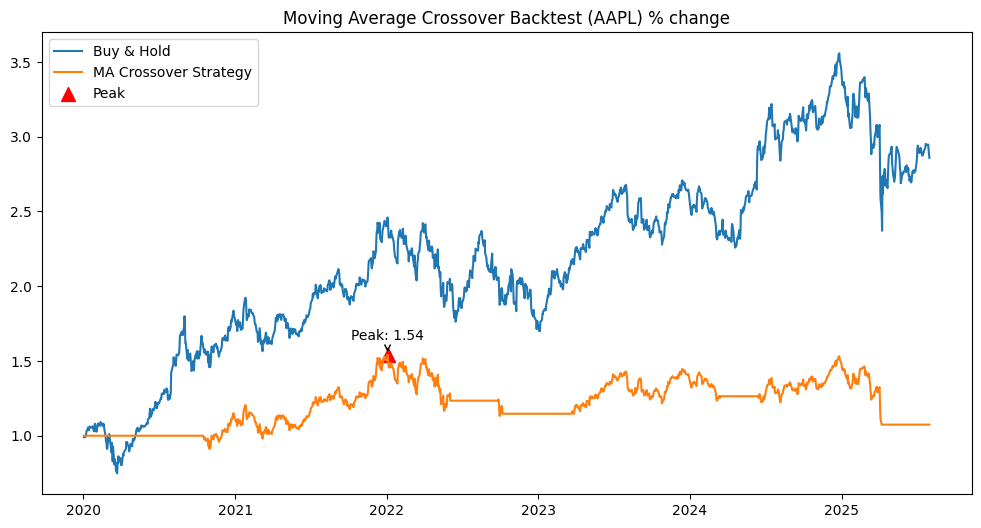

In [37]:
plt.figure(figsize=(12,6))
plt.plot(data['Cumulative_Market'], label='Buy & Hold')
plt.plot(data['Cumulative_Strategy'], label='MA Crossover Strategy')
peak_idx = data['Cumulative_Strategy'].idxmax()
peak_val = data['Cumulative_Strategy'].max()

# Mark the peak
plt.scatter(peak_idx, peak_val, color='red', s=100, marker='^', label='Peak')

# Annotate the peak
plt.annotate(f'Peak: {peak_val:.2f}',
             xy=(peak_idx, peak_val),
             xytext=(peak_idx, peak_val + 0.1),  # offset a bit above the marker
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             horizontalalignment='center')
plt.legend()
plt.title("Moving Average Crossover Backtest (AAPL) % change")
plt.show()


In [35]:
 # Position changes (1 = buy, -1 = sell)  we trade on the basis of this position change
data['Position'] = data['Signal'].diff() ### checks the difference of signal bw Nth day and N-1th day. it can be either 0 (meaning no change), 1 (ma50 is higher than ma200) meaning buy or -1 meaning sell.

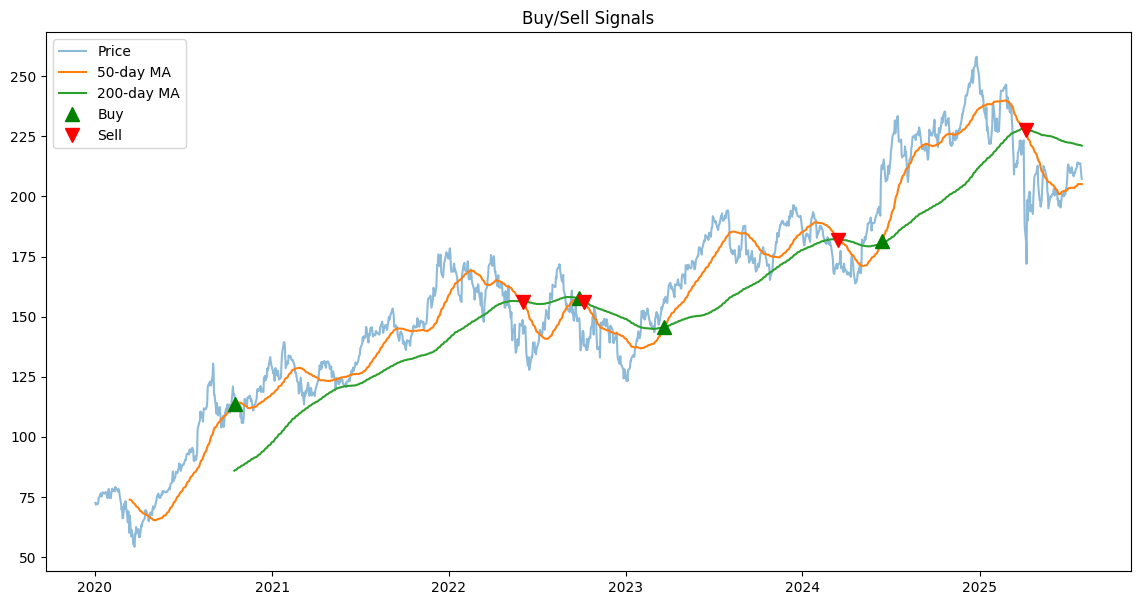

In [36]:
plt.figure(figsize=(14,7))
plt.plot(data['Close'], label='Price', alpha=0.5)
plt.plot(data['MA50'], label='50-day MA')
plt.plot(data['MA200'], label='200-day MA')

# Buy signals
plt.plot(data[data['Position'] == 1].index,
         data['MA50'][data['Position'] == 1],
         '^', markersize=10, color='g', label='Buy')

# Sell signals
plt.plot(data[data['Position'] == -1].index,
         data['MA50'][data['Position'] == -1],
         'v', markersize=10, color='r', label='Sell')

plt.legend()
plt.title("Buy/Sell Signals")
plt.show()
